## Outliers detection for RFM data


In [1]:
import numpy as np
import pandas as pd
import plotly.express as px

from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import QuantileTransformer


In [2]:
rfm = pd.read_csv("./../../data/rfm.csv")

In [3]:
# Cleaning
rfm = rfm.dropna()
rfm = rfm.query("recency > 0 & frequency > 0 and monetary > 0")
min_recency = rfm.recency.min()

rfm["recency"] = (rfm.recency - min_recency) + 1

In [4]:
# Transforming
scaler = QuantileTransformer(random_state=0, output_distribution="normal")
scaler.fit(rfm)

scaled_customers = scaler.transform(rfm)

In [5]:
# Outlier detection
nearest_neighbors = NearestNeighbors(n_neighbors=6).fit(scaled_customers)
distances, idx = nearest_neighbors.kneighbors(scaled_customers)
distances = np.sort(distances, axis=0)
distances = distances[:, 1]
fig = px.line(None, y=distances, title="Evaluation of epsilon")
fig.show()

eps  n_clusters  noise_points  silhouette_score
0  0.40           5           159          0.406161
1  0.45           4           124          0.487862
2  0.50           5            80          0.487978
3  0.55           5            61          0.499100
4  0.60           6            40          0.495601
5  0.65           5            32          0.499336

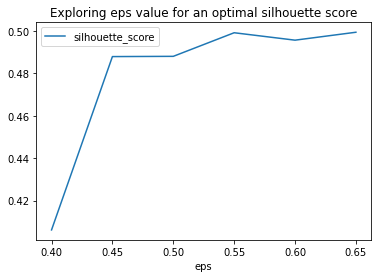

In [6]:
# Compute DBSCAN
report = []
for eps_value in np.arange(0.4, 0.7, 0.05):
    dbscan = DBSCAN(eps=eps_value, min_samples=6, n_jobs=4).fit(scaled_customers)
    labels = dbscan.labels_

    # Number of clusters in labels, ignoring noise if present.
    n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
    n_noise_ = list(labels).count(-1)
    score = silhouette_score(scaled_customers, labels)
    report.append(
        {
            "eps": eps_value,
            "n_clusters": n_clusters_,
            "noise_points": n_noise_,
            "silhouette_score": score,
        }
    )

df_report = pd.DataFrame(report)
df_report.plot(
    title="Exploring eps value for an optimal silhouette score",
    x="eps",
    y="silhouette_score",
)

df_report

In [7]:
# Compute DBSCAN with the best parameters 
dbscan = DBSCAN(eps=0.45, min_samples=6).fit(scaled_customers)
labels = dbscan.labels_

In [8]:
# Remove the outliers
labeled_customers = pd.DataFrame(scaled_customers)
rfm["clusters"] = labels

rfm = rfm[rfm.clusters != -1]

In [9]:
print(rfm.clusters.value_counts())

0    136290
1        11
2        10
3         4
Name: clusters, dtype: int64


In [10]:
# Dump file for further analyzes
rfm.to_csv('./../../data/cleaned/rfm.csv', index=False)